#### Datasets required:

`sie.csv`; `ACCfronts.csv`; `sst.mnmean.nc`; `lsmask.nc`; `icec.mnmean.nc`; `en4_monthly_mixed_layer_depth_median.nc`; `era5_storm_interstorm_periods_1981_2023_DJF.nc`; `sam_ds.nc`; `mean_summer_winds_fluxes_1981_2023.nc`

In [1]:
# load the modules that we will need

from functions.map_plotting import southern_ocean_map
from functions.detrend_dim import detrend_dim
from functions.adjust_lon_xr_dataset import adjust_lon_xr_dataset
from functions import plot_params

import numpy as np
import xarray as xr

import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cmocean.cm as cmo

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# load the ACC fronts and sea ice edge locations 

import pandas as pd

sie = pd.read_csv('../../data/seaice/sie.csv').to_xarray().drop('Unnamed: 0')
fronts = pd.read_csv('../../data/fronts/ACCfronts.csv').to_xarray().drop('Unnamed: 0')

In [3]:
# Load the SST datasets

sst_noaa = xr.open_dataset('../../data/sst/sst.mnmean.nc')
lsm_noaa = xr.open_dataset('../../data/sst/lsmask.nc')
sic_noaa = xr.open_dataset('../../data/seaice/icec.mnmean.nc')

In [4]:
# Mask out sst data where there is sea ice in the sst noaa dataset

# Assuming sic_noaa is your xarray dataset with a variable 'icec'

# Create a mask for seaice values greater than 5
date_mask = sic_noaa.icec < 1

# Create a replacement array with NaN values for the same shape as sic_noaa
replacement_array = xr.full_like(sic_noaa.icec, fill_value=np.nan, dtype=float)

# Combine the original data and the replacement array
sic_noaa_filtered = replacement_array.combine_first(sic_noaa.icec.where(date_mask))

sst_noaa_filtered = replacement_array.combine_first(sst_noaa.sst.where(date_mask))


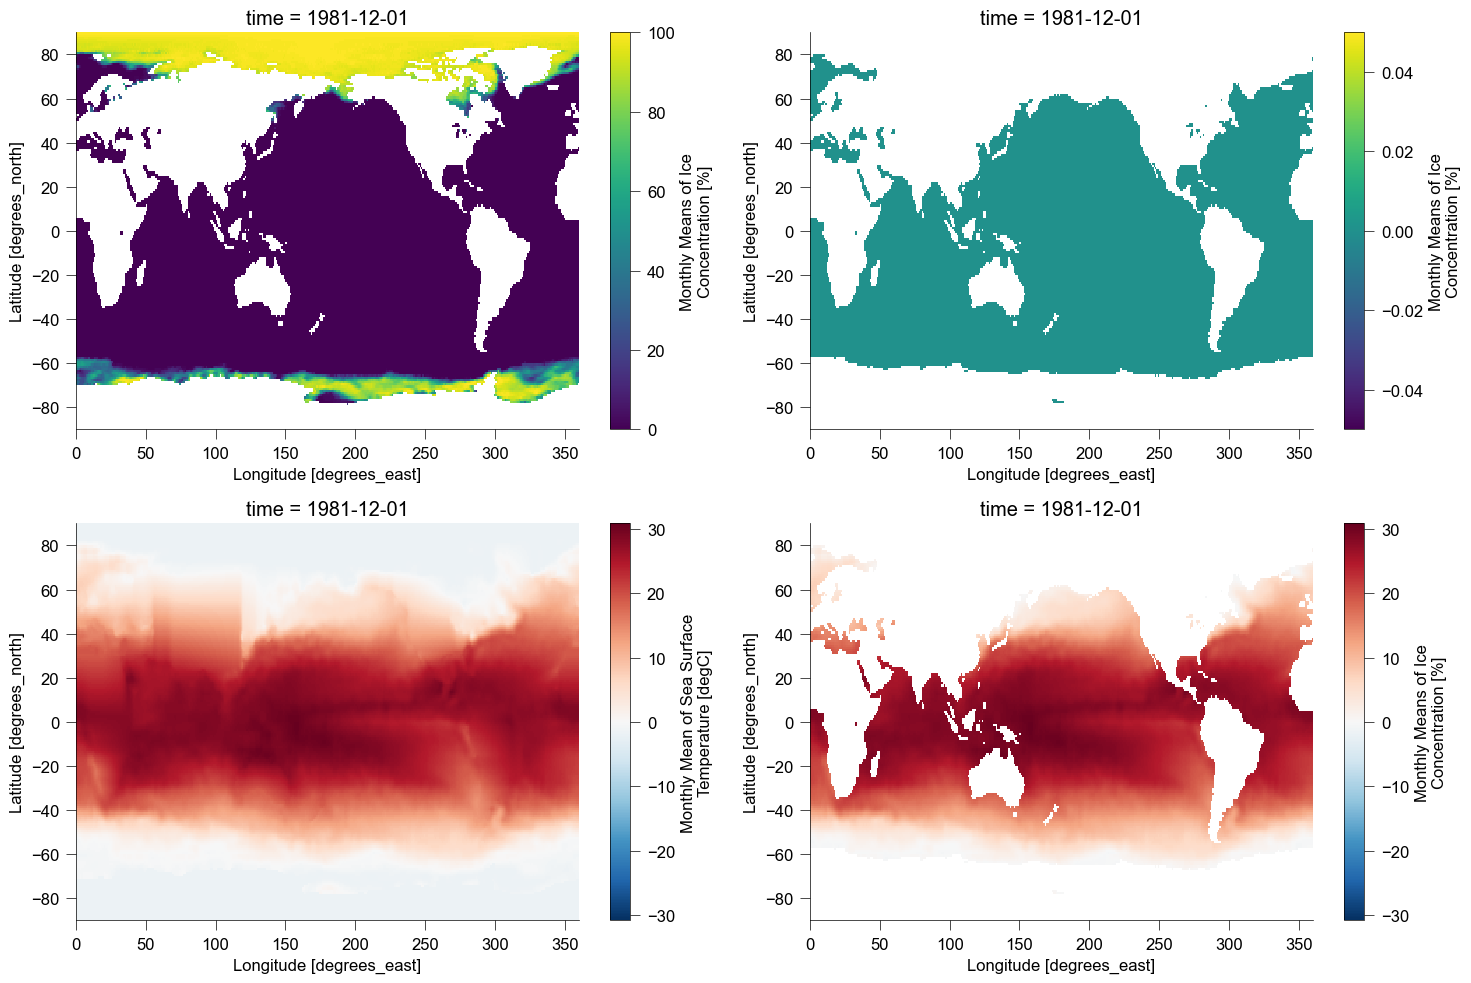

In [5]:
# #### Check that the masks worked

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

sic_noaa.icec.isel(time=0).plot(ax=ax[0,0])
sic_noaa_filtered.isel(time=0).plot(ax=ax[0,1])

sst_noaa.sst.isel(time=0).plot(ax=ax[1,0])
sst_noaa_filtered.isel(time=0).plot(ax=ax[1,1])

fig.tight_layout()

In [6]:
# laod the mixed layer depth

mld_month = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/en4_monthly_mixed_layer_depth_median.nc').load()

In [7]:
# truncate the sst dataset to fit the time of the mld dataset

sst_noaa_filtered_truncated = sst_noaa_filtered.sel(time=slice('2004-01-01', '2023-12-31'), lat=slice(-35, -90))

sst_noaa_filtered_truncated = sst_noaa_filtered_truncated.load()

In [8]:
# reorder the longitudes of sst from 0-360 to -180 to 180

from functions.adjust_lon_xr_dataset import adjust_lon_xr_dataset

sst_noaa_filtered_truncated = adjust_lon_xr_dataset(sst_noaa_filtered_truncated, lon_name='lon')

In [9]:
# now truncate the mld dataset to fit the size of the sst dataset and interp the mld to be the same resolution as the sst

mld_month = mld_month.isel(time=np.arange(sst_noaa_filtered_truncated.time.size))

mld_month['time'] = (('time'), sst_noaa_filtered_truncated.time.values)

sst_noaa_filtered_truncated = sst_noaa_filtered_truncated.interp_like(mld_month)

In [10]:
# Mask out data in the mld dataset where there is no sst

# Create a mask for sst values greater than -2
date_mask = sst_noaa_filtered_truncated > -2

# Create a replacement array with NaN values for the same shape as sst_noaa_filtered_truncated
replacement_array = xr.full_like(sst_noaa_filtered_truncated, fill_value=np.nan, dtype=float)

# Combine the original data and the replacement array
mld_month_interp_filtered = replacement_array.combine_first(mld_month.where(date_mask))

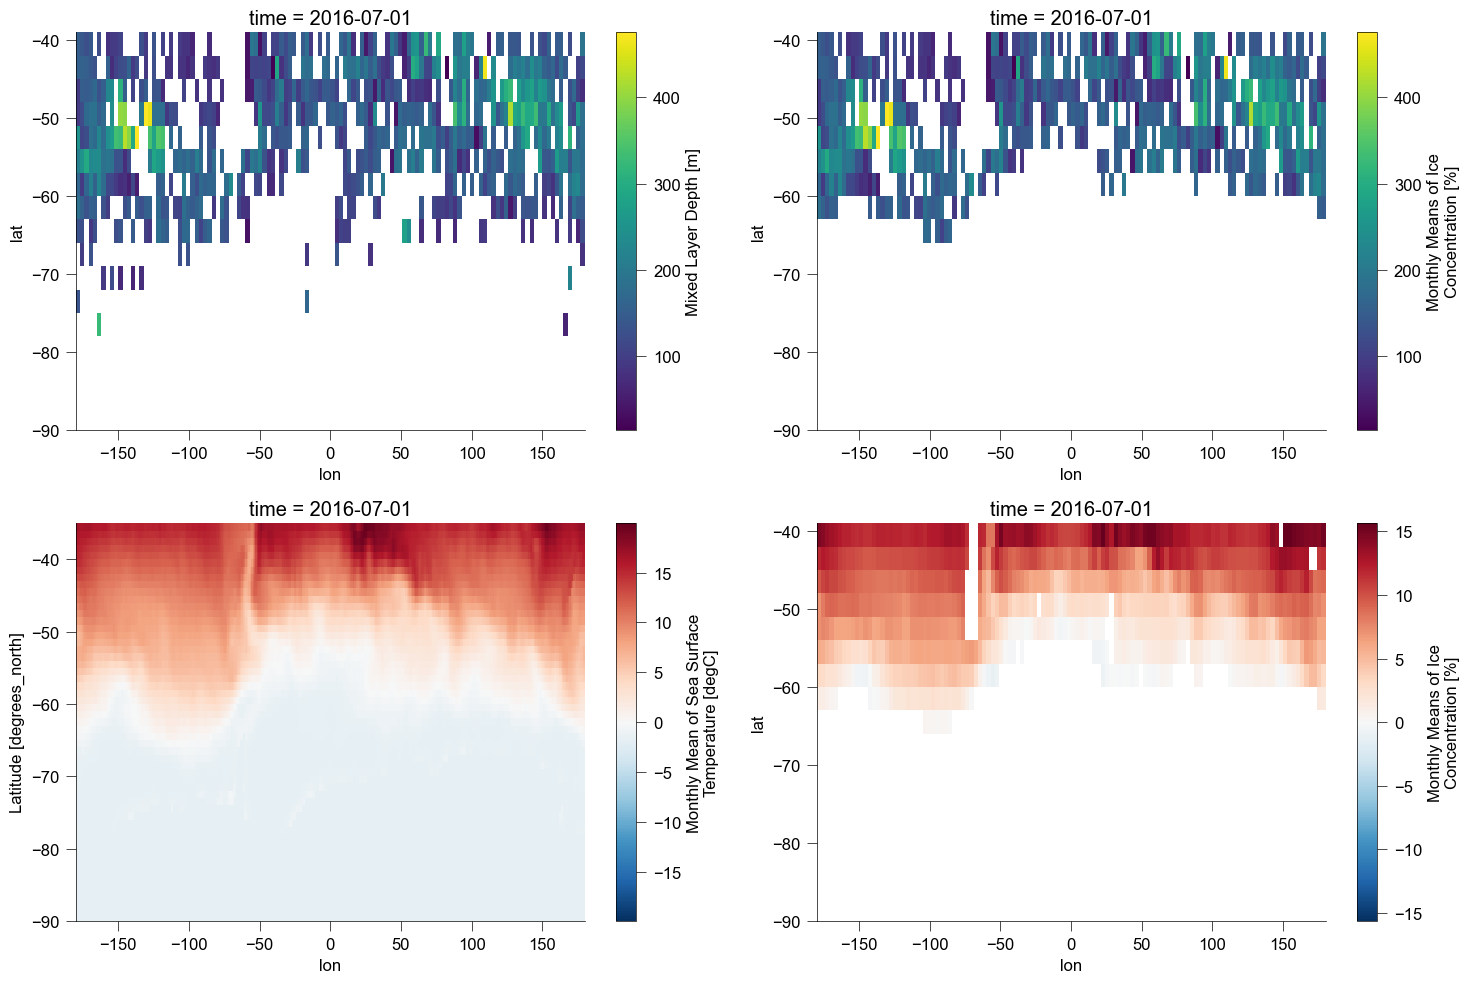

In [11]:
# #### Check that the masks worked

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

t=150

mld_month.MLD.T.isel(time=t).plot(ax=ax[0,0])
mld_month_interp_filtered.MLD.isel(time=t).plot(ax=ax[0,1])

sst = adjust_lon_xr_dataset(sst_noaa.sel(time=sst_noaa_filtered_truncated.isel(time=t).time, lat=slice(-35, -90)), lon_name='lon')

sst.sst.plot(ax=ax[1,0])
sst_noaa_filtered_truncated.isel(time=t).plot(ax=ax[1,1])

#ax[0,0].plot(sic_dec.lon, lat_sie, c='k')
#ax[1,1].plot(sic_dec.lon, lat_sie, c='k')

fig.tight_layout()

In [12]:
from tqdm.notebook import tqdm

# filter out only the summer months and calculate seasonal mld statistics

mld_month_interp_filtered['year'] = mld_month_interp_filtered['time.year']
mld_month_interp_filtered['month'] = mld_month_interp_filtered['time.month']

full_idx = np.arange(mld_month_interp_filtered.time.size)

years = np.arange(2004, 2023)

mld_seasonal_mean  = np.ndarray([years.size, mld_month_interp_filtered.lat.size, mld_month_interp_filtered.lon.size])
mld_seasonal_max   = np.ndarray([years.size, mld_month_interp_filtered.lat.size, mld_month_interp_filtered.lon.size])
mld_seasonal_range = np.ndarray([years.size, mld_month_interp_filtered.lat.size, mld_month_interp_filtered.lon.size])

for i, year in tqdm(enumerate(years)):

    idx1 = full_idx[((mld_month_interp_filtered.year==year)   & (mld_month_interp_filtered.month==12))]
    idx2 = full_idx[((mld_month_interp_filtered.year==year+1) & (mld_month_interp_filtered.month==1))]
    idx3 = full_idx[((mld_month_interp_filtered.year==year+1) & (mld_month_interp_filtered.month==2))]
    
    idx = np.concatenate((idx1, idx2, idx3))
    
    mld_seasonal_mean[i]   = mld_month_interp_filtered['MLD'].isel(time=idx).mean(dim='time', skipna=True)
    mld_seasonal_max[i]    = mld_month_interp_filtered['MLD'].isel(time=idx).max(dim='time')
    mld_seasonal_range[i]  = mld_month_interp_filtered['MLD'].isel(time=idx).max(dim='time') - mld_month_interp_filtered['MLD'].isel(time=idx).min(dim='time')

0it [00:00, ?it/s]

In [13]:
# create an xarray dataset with the gridded seasonal mean mld  

# Define shared dimensions and coordinates
dims = ['time', 'lat', 'lon']
coords = {
    'time': years,
    'lat': mld_month_interp_filtered.lat,
    'lon': mld_month_interp_filtered.lon
}

# Step 1: Prepare your data arrays
# Assuming you have data arrays for MLD_MEAN, MLD_MAX, and MLD_RANGE
# For demonstration, let's create dummy data arrays
mld_mean_data = xr.DataArray(
    data=mld_seasonal_mean,
    dims=dims,
    coords=coords
)

mld_max_data = xr.DataArray(
    data=mld_seasonal_max,
    dims=dims,
    coords=coords
)

mld_range_data = xr.DataArray(
    data=mld_seasonal_range,
    dims=dims,
    coords=coords
)

# Step 2: Create the initial dataset with one variable
initial_ds = xr.Dataset({
    'MLD_MEAN': mld_mean_data  # Start with MLD_MEAN as the initial variable
}, coords=coords)

# Step 3: Add the remaining variables using assign
mld_season = initial_ds.assign({
    'MLD_MAX': mld_max_data,
    'MLD_RANGE': mld_range_data
})


In [14]:
# check what propotion of the seasons contain an mld data point

mld_density = np.ndarray([mld_season.lat.size, mld_season.lon.size])

for i, ln in enumerate(mld_season.lon):
    for ii, lt in enumerate(mld_season.lat):
        mld_density[ii,i] = mld_season.isel(lon=i, lat=ii).MLD_MEAN.count()

In [15]:
# extended data figure 7

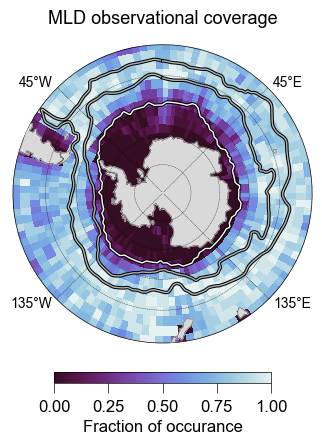

In [16]:
fig = plt.figure(figsize=(4, 5))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

ax = southern_ocean_map(ax)

img=ax.pcolormesh(mld_season.lon, mld_season.lat, mld_density/19, transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap=cmo.dense_r)

props = dict(pad=15, fontsize=13)

ax.set_title('MLD observational coverage', **props)
    
cb = plt.colorbar(mappable=img, ax=ax, orientation='horizontal', shrink=0.7, pad=0.075)
cb.set_label('Fraction of occurance')

# plot the fronts and grid

gl = ax.gridlines(ls='--', color='k', lw=0.25, zorder=100)
gl.xlocator = mticker.FixedLocator([-135, -45, 45, 135])  # Specify the longitudes for the gridlines

# plot the fronts 

ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

# plot the sea ice 

ax.plot(sie['si_lon'], sie['si_lat'], c='k', lw=2.5, transform=ccrs.PlateCarree(), zorder=110)
ax.plot(sie['si_lon'], sie['si_lat'], c='w', lw=1, transform=ccrs.PlateCarree(), zorder=110)

# ax.scatter(0, -54, s=200, marker='*', c='gold', edgecolor='k', lw=0.75, zorder=120, transform=ccrs.PlateCarree())

plt.savefig('../../figs/ext-data-figure-7.png', dpi=300)

In [17]:
# southern ocean ice-free mld mean

mld_clim_ravel = np.ravel(mld_season.MLD_MEAN.mean(dim='time'))

mld_season_mean = mld_season['MLD_MEAN'].mean(dim=('lat', 'lon'))
mld_season_stde = mld_season['MLD_MEAN'].std(dim=('lat', 'lon')) / np.sqrt(mld_clim_ravel[mld_clim_ravel>0].size)

mld_clim = mld_season_mean.mean(dim=('time'))
mld_anom = mld_season_mean - mld_clim
mld_detr = detrend_dim(mld_anom,'time', 1)

In [18]:
# calculate seasonal max sst

sst_noaa_filtered['year'] = sst_noaa_filtered['time.year']
sst_noaa_filtered['month'] = sst_noaa_filtered['time.month']

from tqdm.notebook import tqdm

full_idx = np.arange(sst_noaa_filtered.time.size)

years = np.arange(1981, 2023)

sst_noaa_seasonal_mean = np.ndarray([years.size, sst_noaa_filtered.lat.size, sst_noaa_filtered.lon.size])
sst_noaa_seasonal_max = np.ndarray([years.size, sst_noaa_filtered.lat.size, sst_noaa_filtered.lon.size])
sst_noaa_seasonal_range = np.ndarray([years.size, sst_noaa_filtered.lat.size, sst_noaa_filtered.lon.size])

for i, year in tqdm(enumerate(years)):

    idx1 = full_idx[((sst_noaa_filtered.year==year)   & (sst_noaa_filtered.month==12))]
    idx2 = full_idx[((sst_noaa_filtered.year==year+1) & (sst_noaa_filtered.month==1))]
    idx3 = full_idx[((sst_noaa_filtered.year==year+1) & (sst_noaa_filtered.month==2))]
    
    idx = np.concatenate((idx1, idx2, idx3))
    
    sst_noaa_seasonal_mean[i]   = sst_noaa_filtered.isel(time=idx).mean(dim='time', skipna=False)
    sst_noaa_seasonal_max[i]    = sst_noaa_filtered.isel(time=idx).max(dim='time', skipna=False)
    sst_noaa_seasonal_range[i]  = sst_noaa_filtered.isel(time=idx).max(dim='time', skipna=False) - sst_noaa_filtered.isel(time=idx).min(dim='time', skipna=False)

    sst_noaa_seasonal_mean[i] = sst_noaa_seasonal_mean[i] * lsm_noaa.mask
    sst_noaa_seasonal_max[i] = sst_noaa_seasonal_max[i] * lsm_noaa.mask
    sst_noaa_seasonal_range[i] = sst_noaa_seasonal_range[i] * lsm_noaa.mask

0it [00:00, ?it/s]

In [19]:
# Create an xarray dataset of only the summer statistics of the sea surface temperature

ds_sst_summer = xr.Dataset(
    {
        'sst_mean': (['time', 'latitude', 'longitude'], sst_noaa_seasonal_mean),
        'sst_max': (['time', 'latitude', 'longitude'], sst_noaa_seasonal_max),
        'sst_range': (['time', 'latitude', 'longitude'], sst_noaa_seasonal_range),
    },
    coords={
        'years': years,
        'latitude': sst_noaa.lat.data,
        'longitude': sst_noaa.lon.data,
    },
)

# Assign units and metadata 

ds_sst_summer['sst_mean'].attrs['units'] = 'degrees Celsius'
ds_sst_summer.attrs['description'] = 'NOAA OI SST V2 SST data DJF seasonal means'

ds_sst_summer = adjust_lon_xr_dataset(ds_sst_summer)

ds_sst_summer = ds_sst_summer.sel(latitude=slice(-40, -90))

years_array = ds_sst_summer.years.data

years = np.array([f'{year}-12-01' for year in years_array], dtype='datetime64')

ds_sst_summer['time'] = (('time'), years)

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_25283/1118724353.py:29: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_sst_summer['time'] = (('time'), years)
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_25283/1118724353.py:29: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the 

In [20]:
# find the trend in summer sst

sst_trend = np.ndarray([ds_sst_summer['longitude'].size, ds_sst_summer['latitude'].size])

# Take a look at the trend in the SST data

for i, ln in tqdm(enumerate(ds_sst_summer['longitude'])):
    
    for j, lt in enumerate(ds_sst_summer['latitude']):
        
        # Select the SST data for the specific lon and lat
        sst = ds_sst_summer.sel(latitude=lt, longitude=ln)['sst_max']
        
        # Get the non-NaN indices
        non_nan_indices = ~np.isnan(sst)

        # How many non-nan values are there?
        data_points = sst.count().data
        
        # If there are only non-NaN values for the full time series, calculate the trend
        if data_points == 42:
            time_indices = np.arange(sst.time.size)
            trend = np.polyfit(time_indices[non_nan_indices], sst[non_nan_indices] - sst.mean(), deg=1)[0]
            sst_trend[i, j] = trend
        
        else:
            # If all values are NaN, set the trend to NaN
            sst_trend[i, j] = np.nan


0it [00:00, ?it/s]

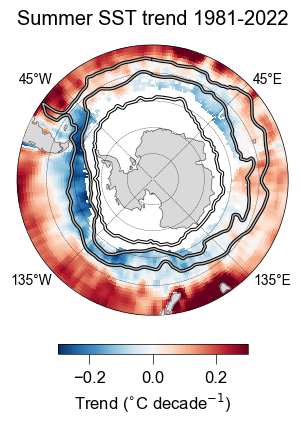

In [21]:
# lets see what the trend looks like

# plot the sst trend

fig = plt.figure(figsize=[3.5, 5])

ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

ax = southern_ocean_map(ax)

img = ax.pcolormesh(ds_sst_summer.longitude, ds_sst_summer.latitude, sst_trend.T*10, cmap='RdBu_r', vmin=-0.3, vmax=0.3, transform=ccrs.PlateCarree())

cb = plt.colorbar(mappable=img, ax=ax, orientation='horizontal', shrink=0.7, pad=0.075)

cb.set_label('Trend ($^{\circ}$C decade$^{-1}$)')

ax.set_title('Summer SST trend 1981-2022', pad=15)

# plot the fronts and grid

gl = ax.gridlines(ls='--', color='k', lw=0.25, zorder=100)
gl.xlocator = mticker.FixedLocator([-135, -45, 45, 135])  # Specify the longitudes for the gridlines

# plot the fronts 

ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

# plot the sea ice 

ax.plot(sie['si_lon'], sie['si_lat'], c='k', lw=2.5, transform=ccrs.PlateCarree(), zorder=110)
ax.plot(sie['si_lon'], sie['si_lat'], c='w', lw=1, transform=ccrs.PlateCarree(), zorder=110)

In [22]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [23]:
# load the ds_storms dataset

ds_storms = xr.open_dataset('../../data/era5/era5_storm_interstorm_periods_1981_2023_DJF.nc')

years_array = ds_storms.time.data

years = np.array([f'{year}-12-01' for year in years_array], dtype='datetime64')

ds_storms['time'] = (('time'), years)

ds_storms = ds_storms.interp_like(ds_sst_summer)

In [24]:
# remove sea ice locations by identifying locations with NaN values in the SST variable and apply these to the storm and interstorm datasets

nan_mask_sst = np.isnan(ds_sst_summer['sst_mean'])

# Mask the wind variable based on the NaN locations in SST

storm_vars = [d for d in ds_storms.data_vars]

for f in storm_vars:

    ds_storms[f] = (('time', 'latitude', 'longitude'), np.where(nan_mask_sst, np.nan, ds_storms[f]))
    ds_storms[f] = ds_storms[f].where(ds_storms[f] != 0, np.nan)

In [25]:
# sst anomalies - calculate sst_max clim and remove from sst_max to create anomaly

sst_clim = ds_sst_summer.mean(dim='time', skipna=False)
sst_anom = ds_sst_summer.sst_max - sst_clim.sst_max


In [26]:
# detrend data the sst anomaly

det_anom_sst = detrend_dim(sst_anom,'time',1)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [27]:
# standardize the detrended sst_max anomalies 

year_mean_anom_sst = det_anom_sst.mean('time')
year_std_anom_sst = det_anom_sst.std('time')
stand_anom_sst = xr.apply_ufunc(
                                  lambda x, m, s: (x - m) / s,
                                  det_anom_sst.groupby('time.year'),
                                  year_mean_anom_sst, year_std_anom_sst)


In [28]:
# change the structure of detrended sst_max anomalies dataset into an xarray data array 

stand_sst = stand_anom_sst.to_dataset(name='standardize_anom_sst')
stand_sst = stand_sst.standardize_anom_sst

In [29]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of latitude weights are applied before the computation of EOFs.

from eofs.xarray import Eof

coslat = np.cos(np.deg2rad(stand_sst.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(stand_sst, weights=wgts)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [30]:
# Retrieve the leading EOF, expressed as the correlation between the leading PC time series and the input SST anomalies at each grid point, and the leading PC time series itself.

eof1 = solver.eofsAsCorrelation(neofs=10)
pc1 = solver.pcs(npcs=5, pcscaling=1)

In [31]:
# Calculate the eigenvalues: cumulative explained variance

eigenvalues = solver.varianceFraction()

cumulative_variance = np.cumsum(eigenvalues)

In [32]:
# extended data figure 6

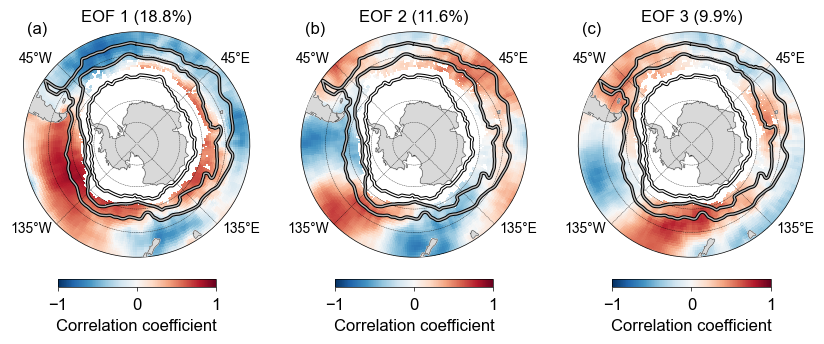

In [33]:
# plot the first 3 eofs

fig = plt.figure(figsize=[8.5, 3.5])

num = ['(a)', '(b)', '(c)']

for i in range(3):

    ax = fig.add_subplot(1, 3, i+1, projection=ccrs.SouthPolarStereo())

    eof = eof1.isel(mode=i)

    img=ax.pcolormesh(eof1.longitude, eof1.latitude, eof, cmap='RdBu_r', vmin=-1, vmax=1, transform=ccrs.PlateCarree())

    ax.set_extent([-180, 180, -90, -35], ccrs.PlateCarree())

    ax = southern_ocean_map(ax)

    cb = plt.colorbar(mappable=img, ax=ax, orientation='horizontal', shrink=0.7, pad=0.075, label='Correlation coefficient')

    cb.ax.tick_params(axis='both', which='both', width=0.5, length=3)

    ax.set_title(label='EOF ' + str(i+1) + ' (' + str(100 * np.round(eigenvalues[i].data, 3))[:4] + '%)', pad=7, fontsize=12)
    
    # plot the fronts and grid       

    gl = ax.gridlines(ls='--', color='k', lw=0.25, zorder=100)
    gl.xlocator = mticker.FixedLocator([-135, -45, 45, 135])  # Specify the longitudes for the gridlines       

    # plot the fronts 
    
    ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
    ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)
    
    ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
    ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)
    
    # plot the sea ice 
    
    ax.plot(sie['si_lon'], sie['si_lat'], c='k', lw=2.5, transform=ccrs.PlateCarree(), zorder=110)
    ax.plot(sie['si_lon'], sie['si_lat'], c='w', lw=1, transform=ccrs.PlateCarree(), zorder=110)
    
    ax.text(-45, -25, num[i], transform=ccrs.PlateCarree())
    
fig.tight_layout()

plt.savefig('../../../figs/ext-data-figure-6.png', dpi=300)

In [34]:
# extended data figure 5

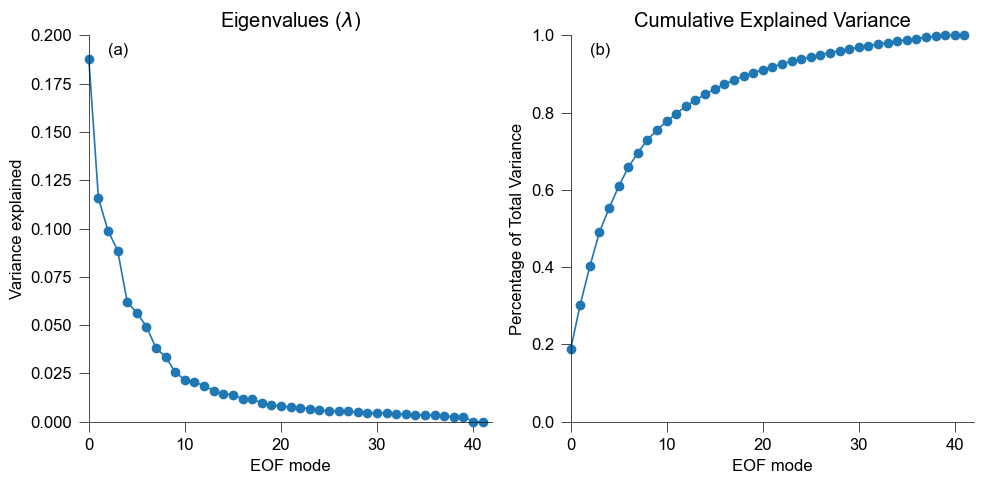

In [35]:
# Plot the eigenvalues and cumulative explained variance

fig, ax = plt.subplots(1,2,figsize=(10, 5))

ax[0].plot(eigenvalues, marker='o', clip_on=False)
ax[0].set_title('Eigenvalues ($\lambda$)')

ax[0].set_ylabel('Variance explained')


ax[1].plot(cumulative_variance, marker='o', clip_on=False)
ax[1].set_title('Cumulative Explained Variance')
ax[1].set_ylabel('Percentage of Total Variance')

for a in ax:
    a.set_xlim(0, 42)
    a.set_xlabel('EOF mode')

ax[0].set_ylim(0, 0.20)
ax[1].set_ylim(0, 1)

ax[0].text(2, 0.19, '(a)')
ax[1].text(2, 0.95, '(b)')

fig.tight_layout()

plt.savefig('../../figs/ext-data-figure-5.png', dpi=300)

In [36]:
# calculate the reconstruction SST from SST anomlaies

rec_sst = solver.reconstructedField(1)

# calculate correlation both for recontructed and observed SST anomalies

corr_both = xr.corr(rec_sst, ds_sst_summer.sst_max, dim="time")

In [37]:
# check the correlation betwen the recreated sst from eof1 and the standardized, detrended sst_max anomalies

rec_sst_mean = rec_sst.mean(dim=('latitude', 'longitude'))
sst_max_mean = stand_sst.mean(dim=('latitude', 'longitude'))

np.corrcoef(rec_sst_mean, sst_max_mean)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


array([[1.        , 0.31417066],
       [0.31417066, 1.        ]])

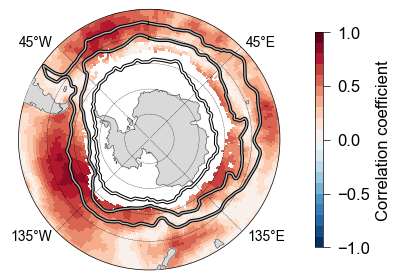

In [38]:
# plot the correlation between the reconstructed sst and sst_max

fig = plt.figure(figsize=[4.5, 3.5])

ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

sst_map = corr_both.plot.pcolormesh(ax=ax, levels=np.arange(-1, 1.1, 0.1), cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())

ax.set_extent([-180, 180, -90, -35], ccrs.PlateCarree())

ax = southern_ocean_map(ax)

cb = plt.colorbar(sst_map, label='Correlation coefficient', aspect=25, shrink=0.8, pad=0.1)

cb.set_ticks(np.arange(-1, 1.5, 0.5))

# plot the fronts and grid    
#    
gl = ax.gridlines(ls='--', color='k', lw=0.25, zorder=100)
gl.xlocator = mticker.FixedLocator([-135, -45, 45, 135])  # Specify the longitudes for the gridlines       

# plot the fronts 

ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

# plot the sea ice 

ax.plot(sie['si_lon'], sie['si_lat'], c='k', lw=2.5, transform=ccrs.PlateCarree(), zorder=110)
ax.plot(sie['si_lon'], sie['si_lat'], c='w', lw=1, transform=ccrs.PlateCarree(), zorder=110)

cb.ax.tick_params(axis='both', which='minor', width=0.5, length=0)
cb.ax.tick_params(axis='both', which='major', width=0.5, length=5)

In [39]:
# load the sam dataset

ds_sam = xr.open_dataset('../../data/sam/sam_ds.nc')

In [53]:
# Extract SAM and ENSO DJF months for each year

djf_sam = ds_sam.resample(time='QS-DEC').mean(dim='time')

djf_sam = ds_sam.sel(time=ds_sam['time.month'].isin([12, 1, 2])).resample(time='AS-DEC').mean(dim='time')

djf_sam = djf_sam.sam_index

# detrend sam

sam_detr = detrend_dim(djf_sam,'time',1) 

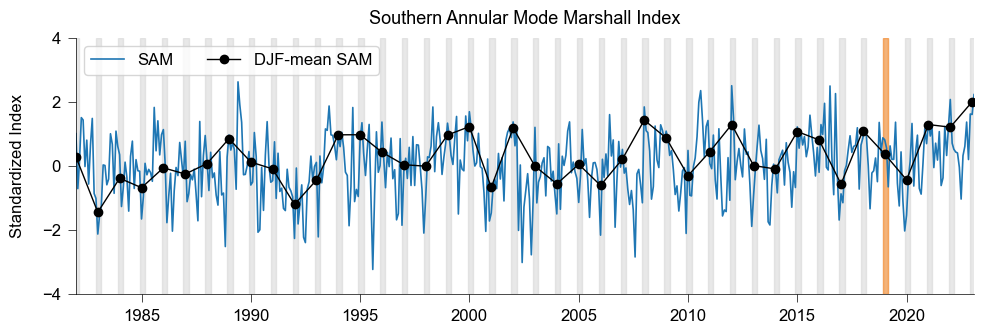

In [43]:
# compare the summer sam indexes to the full sam

fig,ax=plt.subplots(figsize=(10,3.5))

years = pd.date_range('1981-12-01', '2023-12-01', freq='Y')

# ax.plot(ds_sam.time, ds_sam.sam_index)
ax.plot(ds_sam.time, ds_sam_standardized.sam_index, label='SAM')

ax.set_xlim(ds_sam.time[0], ds_sam.time[-1])

#x Adjust the size of both major and minor ticks
ax.tick_params(axis='both', which='major', size=6)  # You can adjust 'labelsize' as needed
ax.tick_params(axis='x', which='minor', size=3)   # You can adjust 'labelsize' as needed

# Shade the DJF months
for year in range(1981, 2024):
    # December of the previous year to February of the current year
    ax.axvspan(pd.Timestamp(f'{year-1}-12-01'), pd.Timestamp(f'{year}-02-28'), color='lightgrey', alpha=0.5)

ax.axvspan(pd.Timestamp('2018-12-01'), pd.Timestamp('2019-02-28'), color='tab:orange', alpha=0.5)

ax.plot(years, djf_sam, c='k', lw=1, markersize=12, marker='.', label='DJF-mean SAM')

ax.set_ylim(-4, 4)
ax.legend(ncol=2, loc=2)

ax.set_title('Southern Annular Mode Marshall Index', fontsize=13, pad=10)
ax.set_ylabel('Standardized Index', labelpad=12)

fig.tight_layout()

In [73]:
# calculate detrended sst_max anomaly

sst_mean = ds_sst_summer['sst_max'].mean(dim=('longitude', 'latitude'))
sst_clim = sst_mean.mean(dim=('time'))
sst_anom = sst_mean - sst_clim
sst_detr = detrend_dim(sst_anom,'time',1)

In [74]:
# load the mean summer flux and winds from 1981 to 2023 

ds_mean = xr.open_dataset('../../data/era5/mean_summer_winds_fluxes_1981_2023.nc')

ds_mean['time'] = ds_sst_summer.time.data
ds_mean = ds_mean.interp_like(ds_sst_summer)

In [75]:
# calculate detrended qnet anomaly

qnet_mean = ds_mean.qnet.mean(dim=('latitude', 'longitude'))
qnet_clim = qnet_mean.mean(dim=('time'))
qnet_anom = qnet_mean - qnet_clim
qnet_detr = detrend_dim(qnet_anom,'time',1)

In [76]:
# calculate detrended total storm days

tsd_mean = ds_storms['storm_period_total_days'].mean(dim=('latitude', 'longitude'))
tsd_clim = tsd_mean.mean(dim=('time'))
tsd_anom = tsd_mean - tsd_clim
tsd_detr = detrend_dim(tsd_anom,'time',1)

In [77]:
# calculate detrended wind speed anomaly

ws_mean = ds_mean['ws'].mean(dim=('latitude', 'longitude'))
ws_clim = ws_mean.mean(dim=('time'))
ws_anom = ws_mean - ws_clim
ws_detr = detrend_dim(ws_anom,'time',1)

In [78]:
# select the first principle component of the detrended sst_max

pc = pc1.isel(mode=0)

In [79]:
# figure 5a-c

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


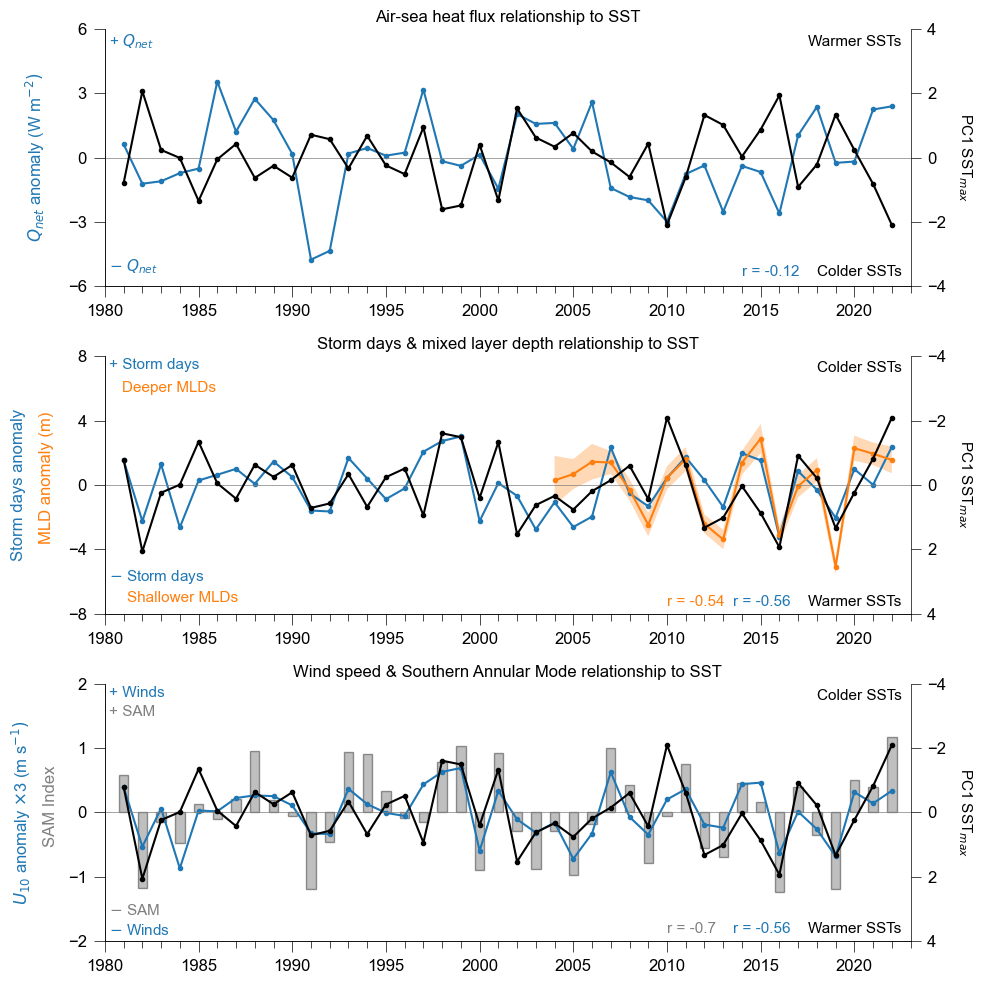

In [80]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(3, figsize=(10, 10))

pc_years = np.arange(1981, 2023, 1)

props = dict(markersize=6, marker='.', lw=1.5)

# net heat flux anomaly
ax[0].plot(pc_years, qnet_detr, **props)

# total non-storm days
ax[1].plot(pc_years, tsd_detr, **props)

# # mixed layer depth
ax[1].plot(mld_season.time, mld_detr, **props, c='tab:orange')
ax[1].fill_between(mld_season.time, mld_detr+mld_season_stde, mld_detr-mld_season_stde, alpha=0.3, facecolor='tab:orange')

# wind speed
ax[2].plot(pc_years, ws_detr*3, **props)

# # sam
ax[2].bar(pc_years[sam_detr>0], sam_detr[sam_detr>0], width=0.5, edgecolor='0.2', alpha=0.5, lw=1,  zorder=0, facecolor='0.5')
ax[2].bar(pc_years[sam_detr<0], sam_detr[sam_detr<0], width=0.5, edgecolor='0.2', alpha=0.5, lw=1, zorder=0, facecolor='0.5')

ax[0].set_ylim(-6, 6)
ax[1].set_ylim(-8, 8)
ax[2].set_ylim(-2, 2)

ax[0].yaxis.set_ticks(np.arange(-6, 9, 3))
ax[1].yaxis.set_ticks(np.arange(-8, 12, 4))

for i, a in enumerate(ax):

    a.set_xlim(1980, 2022)
    
    # Adjust the size of both major and minor ticks
    a.tick_params(axis='both', which='major', size=8) 
    a.tick_params(axis='both', which='minor', size=5)  
    a.tick_params(axis='x', which='minor', size=5) 

    # Set minor x ticks at specific locations using np.arange
    minor_ticks = np.arange(1981, 2024, 1)
    a.xaxis.set_minor_locator(MultipleLocator(base=1))
    a.set_xticks(minor_ticks, minor=True)

    ax_twin = a.twinx()
    ax_twin.plot(pc_years, pc, **props, c='k', label='EOF 1')
    ax_twin.yaxis.set_ticks(np.arange(-4, 6, 2))
    ax_twin.spines['right'].set_visible(True)
    ax_twin.set_ylabel('PC1 SST$_{max}$', labelpad=20, rotation=-90, fontsize=11)

    a.axhline(c='0.5', lw=0.5)

    if i==0:
        ax_twin.set_ylim(-4, 4)
    else:
        ax_twin.set_ylim(4, -4)
    #a.grid(ls='--', c='0.75', zorder=0)

props = dict(fontsize=12, pad=5)

ax[0].set_title('Air-sea heat flux relationship to SST', **props)
ax[1].set_title('Storm days & mixed layer depth relationship to SST', **props)
ax[2].set_title('Wind speed & Southern Annular Mode relationship to SST', **props)

prop=dict(fontsize=11)

ax[0].text(1980.2,  5.2, '+ $Q_{net}$', c='tab:blue', **prop)
ax[0].text(1980.2, -5.3, '$\minus$ $Q_{net}$', c='tab:blue', **prop)

ax[1].text(1980.2, 7.2, '+ Storm days', c='tab:blue', **prop)
ax[1].text(1980.9, 5.8, 'Deeper MLDs', c='tab:orange', **prop)

ax[1].text(1980.2, -6.0, '$\minus$ Storm days', c='tab:blue', **prop)
ax[1].text(1981.2, -7.3, 'Shallower MLDs', c='tab:orange', **prop)

ax[2].text(1980.2, -1.9, '$\minus$ Winds', c='tab:blue', **prop)
ax[2].text(1980.2, -1.6, '$\minus$ SAM', c='0.5', **prop)

ax[2].text(1980.2, 1.8, '+ Winds', c='tab:blue', **prop)
ax[2].text(1980.2, 1.5, '+ SAM', c='0.5', **prop)

ax[0].text(2017.5,  5.2, 'Warmer SSTs', c='k', **prop)
ax[0].text(2018, -5.5, 'Colder SSTs', c='k', **prop)

ax[1].text(2018,   +7.0, 'Colder SSTs', c='k', **prop)
ax[1].text(2017.5, -7.5, 'Warmer SSTs', c='k', **prop)

ax[2].text(2018,   +1.75, 'Colder SSTs', c='k', **prop)
ax[2].text(2017.5, -1.88, 'Warmer SSTs', c='k', **prop)

props = dict(fontsize=11)

# correlations
ax[0].text(2014, -5.5, 'r = ' + str(np.round(np.corrcoef(qnet_detr, pc)[0][1], 2)), c='tab:blue', **props)
ax[1].text(2013.5, -7.5, 'r = ' + str(np.round(np.corrcoef(tsd_detr,  pc)[0][1], 2)), c='tab:blue', **props)
ax[1].text(2010, -7.5, 'r = ' + str(np.round(np.corrcoef(mld_detr, pc[-19:])[0][1], 2)), c='tab:orange', **props)
ax[2].text(2013.5, -1.88, 'r = ' + str(np.round(np.corrcoef(ws_detr, pc)[0][1], 2)), c='tab:blue', **props)
ax[2].text(2010, -1.88, 'r = ' + str(np.round(np.corrcoef(sam_detr, pc)[0][1], 2)), c='0.5', **props)

props = dict(fontsize=12)

ax[0].set_ylabel('$Q_{net}$ anomaly (W m$^{-2})$',   c='tab:blue', **props, labelpad=15)
ax[1].set_ylabel('Storm days anomaly', c='tab:blue', **props, labelpad=30)
ax[2].set_ylabel(r'$U_{10}$ anomaly $\times$3 (m s$^{-1})$', c='tab:blue', **props, labelpad=25)

ax[1].text(1976.5, -3.5, 'MLD anomaly (m)', rotation=90, c='tab:orange', **props)
ax[2].text(1976.7, -0.5, 'SAM Index', rotation=90, c='0.5', **props)

fig.tight_layout()

plt.savefig('../../figs/figure-5ac.png', dpi=300)


In [117]:
# figure 5e-f - plot the maps 

In [62]:
# Identify time steps with NaN values
nan_time_steps = np.any(np.isnan(ds_mean['ws']), axis=0)

# Set all values in time steps with NaN to NaN
ds_wind = ds_mean.ws.where(~nan_time_steps, np.nan)

/Users/xduplm/opt/anaconda3/envs/storms_env/lib/python3.11/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


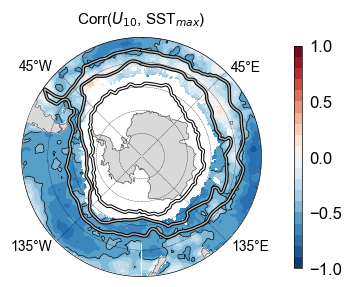

In [63]:
# wind speed - sst detrended anomaly correlation

ws_detr = detrend_dim(ds_mean['ws'],'time',1)

# Calculate correlation
corr_ws_eof = xr.corr(ws_detr, det_anom_sst, dim="time")

# Create a figure and axis
fig = plt.figure(figsize=[3.75, 3.25])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

# Plot contour plot
img = ax.contourf(ds_mean.longitude, ds_mean.latitude, corr_ws_eof, cmap='RdBu_r', levels=np.arange(-1, 1.1, 0.1), transform=ccrs.PlateCarree())
ax.contour(ds_mean.longitude, ds_mean.latitude, corr_ws_eof, colors='k', linestyles='-', linewidths=0.5, levels=np.array([-0.5]), transform=ccrs.PlateCarree())

# Add colorbar with tick size set to 0
cbar = plt.colorbar(img, aspect=25, shrink=0.8, pad=0.1)

# Set custom tick locations
custom_ticks = [-1, -0.5, 0, 0.5, 1]
cbar.set_ticks(custom_ticks)

cbar.ax.tick_params(axis='both', which='both', length=0)  # Set tick size to 0

# Set plot attributes
ax.set_extent([-180, 180, -90, -35], ccrs.PlateCarree())
ax = southern_ocean_map(ax)

# plot the fronts and grid

gl = ax.gridlines(ls='--', color='k', lw=0.25, zorder=100)
gl.xlocator = mticker.FixedLocator([-135, -45, 45, 135])  # Specify the longitudes for the gridlines

# plot the fronts 

ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

# plot the sea ice 

ax.plot(sie['si_lon'], sie['si_lat'], c='k', lw=2.5, transform=ccrs.PlateCarree(), zorder=110)
ax.plot(sie['si_lon'], sie['si_lat'], c='w', lw=1, transform=ccrs.PlateCarree(), zorder=110)

# Add title
ax.set_title(label='Corr($U_{10}$, SST$_{max}$)', pad=10, fontsize=11)

# Save the figure
fig.tight_layout()

plt.savefig('../../figs/figure-5f.png', dpi=300)


/Users/xduplm/opt/anaconda3/envs/storms_env/lib/python3.11/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


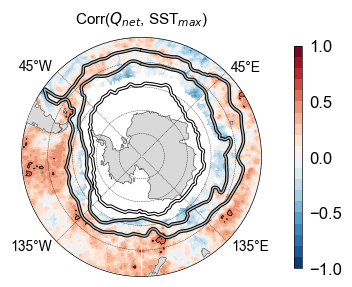

In [65]:
# qnet - sst detrended anomaly correlation

qnet_detr = detrend_dim(ds_mean['qnet'],'time',1)

# Identify time steps with NaN values
nan_time_steps = np.any(np.isnan(qnet_detr), axis=0)

# Set all values in time steps with NaN to NaN
ds_qnet = qnet_detr.where(~nan_time_steps, np.nan)

# Calculate correlation
corr_qnet_eof = xr.corr(ds_qnet, det_anom_sst, dim="time")

# Create a figure and axis
fig = plt.figure(figsize=[3.75, 3.25])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

# Plot contour plot
img = ax.contourf(ds_mean.longitude, ds_mean.latitude, corr_qnet_eof, cmap='RdBu_r', levels=np.arange(-1, 1.1, 0.1), transform=ccrs.PlateCarree())
ax.contour(ds_mean.longitude, ds_mean.latitude, corr_qnet_eof, colors='k', linestyles='-', linewidths=0.5, levels=np.array([0.5]), transform=ccrs.PlateCarree())

# Add colorbar with tick size set to 0
cbar = plt.colorbar(img, aspect=25, shrink=0.8, pad=0.1)

# Set custom tick locations
custom_ticks = [-1, -0.5, 0, 0.5, 1]
cbar.set_ticks(custom_ticks)

cbar.ax.tick_params(axis='both', which='both', length=0)  # Set tick size to 0

# Set plot attributes
ax.set_extent([-180, 180, -90, -35], ccrs.PlateCarree())
ax = southern_ocean_map(ax)

# plot the fronts and grid

gl = ax.gridlines(ls='--', color='k', lw=0.25, zorder=100)
gl.xlocator = mticker.FixedLocator([-135, -45, 45, 135])  # Specify the longitudes for the gridlines

# plot the fronts 

ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

# plot the sea ice 

ax.plot(sie['si_lon'], sie['si_lat'], c='k', lw=2.5, transform=ccrs.PlateCarree(), zorder=110)
ax.plot(sie['si_lon'], sie['si_lat'], c='w', lw=1, transform=ccrs.PlateCarree(), zorder=110)

# Add title
ax.set_title(label='Corr($Q_{net}$, SST$_{max}$)', pad=10, fontsize=11)

# Save the figure
fig.tight_layout()

plt.savefig('../../figs/figure-5d.png', dpi=300)

/Users/xduplm/opt/anaconda3/envs/storms_env/lib/python3.11/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


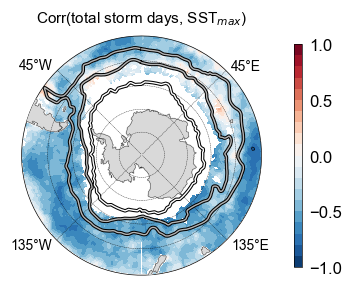

In [84]:
# interstorm days - sst detrended anomaly correlation

tsd_detr = detrend_dim(ds_storms['storm_period_total_days'],'time',1)

# Identify time steps with NaN values
nan_time_steps = np.any(np.isnan(tsd_detr), axis=0)

# Set all values in time steps with NaN to NaN
ds_tsd = tsd_detr.where(~nan_time_steps, np.nan)

# Calculate correlation
corr_tsd_eof = xr.corr(ds_tsd, det_anom_sst, dim="time")

# Create a figure and axis
fig = plt.figure(figsize=[3.75, 3.25])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

# Plot contour plot
img = ax.contourf(ds_storms.longitude, ds_storms.latitude, corr_tsd_eof, cmap='RdBu_r', levels=np.arange(-1, 1.1, 0.1), transform=ccrs.PlateCarree())
ax.contour(ds_storms.longitude, ds_storms.latitude, corr_tsd_eof, colors='k', linestyles='-', linewidths=0.5, levels=np.array([-0.8, 0.8]), transform=ccrs.PlateCarree())

# Add colorbar with tick size set to 0
cbar = plt.colorbar(img, aspect=25, shrink=0.8, pad=0.1)

# Set custom tick locations
custom_ticks = [-1, -0.5, 0, 0.5, 1]
cbar.set_ticks(custom_ticks)

cbar.ax.tick_params(axis='both', which='both', length=0)  # Set tick size to 0

# Set plot attributes
ax.set_extent([-180, 180, -90, -35], ccrs.PlateCarree())
ax = southern_ocean_map(ax)

# plot the fronts and grid

gl = ax.gridlines(ls='--', color='k', lw=0.25, zorder=100)
gl.xlocator = mticker.FixedLocator([-135, -45, 45, 135])  # Specify the longitudes for the gridlines

# plot the fronts 

ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

# plot the sea ice 

ax.plot(sie['si_lon'], sie['si_lat'], c='k', lw=2.5, transform=ccrs.PlateCarree(), zorder=110)
ax.plot(sie['si_lon'], sie['si_lat'], c='w', lw=1, transform=ccrs.PlateCarree(), zorder=110)

# Add title
ax.set_title(label='Corr(total storm days, SST$_{max}$)', pad=10, fontsize=11)

# Save the figure
fig.tight_layout()

plt.savefig('../../figs/figure-5e.png', dpi=300)
